<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI286 - Computación Científica II</h1>
    <h1> Tarea 2: How do planets move? </h1> 
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
    <center>Guillermo Godoy - 201391001-7 </center>
<center>Enero 2020</center>
</p>

---

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Contexto

Ya que la fuerza que ejerce la masa del planeta Tierra hacia el Sol no se compara con la fuerza contraria, es posible modelar nuestra orbita sin tener en cuenta el Sol. Sin embargo existen casos en el que ambas masas son comparables, y en cuyo caso necesitamos analizar ambos cuerpos para poder modelar sus movimientos. Tal es el caso del sistema Alpha Centauri [1], en el cual tres estrellas ejercen fuerzas entre si. También es de interés modelar las interacciones entre átomos de una misma molécula, las cuales se pueden representar de la misma manera como si hablásemos de estrellas. El problema de modelar masas cuya fuerza gravitatoria interactúa entre si es conocido como _N-body Problem_.

Usando las ecuaciones de Newton, es posible representar este problema como un sistema de ecuaciones diferenciales ordinarias de la siguiente forma:

\begin{equation}
    m_i\frac{d^2\mathbf{r}_i}{dt^2}=\sum_{j=1 \, j\neq i}^{n} -G\,m_i\,m_j\frac{\mathbf{r}_i-\mathbf{r}_j}{||\mathbf{r}_i-\mathbf{r}_j||^3}
\end{equation}

donde $i \in [0,n]$, $\mathbf{r}_i=(x_i,y_i,z_i)$ es la posición del cuerpo $i$ en un instante $t$, $n$ es el número de cuerpos en el sistema y $G$ es la constante de gravitación universal.

## Sección 1: Modelo

1. Explique como resolver numéricamente el problema presentado usando el método de euler explícito. Muestre todas las ecuaciones que usará.

R:

\begin{equation}
    V_i = r'_i
\end{equation}
\begin{equation}
    A_i = r''_i
\end{equation}
\begin{equation}
    r(t_0)\ = r_0
\end{equation}

\begin{equation}
    V(t_0)\ = v_0
\end{equation}

$$
R(t) = \left[ \begin{matrix} r_1(t) \\ r_2(t) \\ \vdots \\ r_N(t) \end{matrix} \right] \qquad V(t) = \left[ \begin{matrix} r'_1(t) \\ r'_2(t) \\ \vdots \\ r'_N(t) \end{matrix} \right] \qquad A(t) = \left[ \begin{matrix} r''_1(t) \\ r''_2(t) \\ \vdots \\ r''_N(t) \end{matrix}\right] = \left[ \begin{matrix} f_{1}(t) \\ f_{2}(t) \\ \vdots \\ f_{N}(t) \end{matrix} \right] = F(t,R(t),V(t))
$$

$$
    m_i A_i = m_i \left( \sum_{j=1 \, j\neq i}^{n} -G\,m_j\frac{\mathbf{r}_i-\mathbf{r}_j}{||\mathbf{r}_i-\mathbf{r}_j||^3} \right) \\
$$
\begin{equation}
    A_i = -G\,\sum_{j=1 \, j\neq i}^{n} m_j\frac{\mathbf{r}_i-\mathbf{r}_j}{||\mathbf{r}_i-\mathbf{r}_j||^3}\\
    f(t,r(t),v(t))= G\,\sum_{j=1 \, j\neq i}^{n} m_j\frac{\mathbf{r}_i-\mathbf{r}_j}{||\mathbf{r}_i-\mathbf{r}_j||^3}
\end{equation}

2. Implemente una función que permita calcular númericamente los valores de la posición de los cuerpos a través del tiempo usando distintos métodos de resolución de ODE. Su algoritmo debe permitir resolver la ecuación diferencial con los métodos de Euler y Runge Kutta 4. Use la siguiente firma para su función:


In [2]:

def R(t,y,v):
    return v

def V(t,y,data):
    m = data[0]
    r = data[1]
    resultado = np.zeros((m.size,3))
    G=4.3e-3
    for i in range(m.size):
        for j in range(m.size):
            if i != j:
                deltaR = r[j]-r[i]
                resultado[i] =resultado[i]+(m[j]*((deltaR)/np.linalg.norm(deltaR,3)))
        resultado[i]= resultado[i]*G
    return resultado

# Forward Euler Method + DATA
def euler_ode(y,t,h,f,data):
    return y+h*f(t,y,data)

# Runge-Kutta of Second order
def RK2_ode(y,t,f,h):
    k1=y+h/2.0*f(t,y) #or euler_ode(y,t,f,h)
    return y+h*f(t+h/2.0,k1)
    # k1=h*f(t,y)
    # return y+h*f(t+h/2.0,y+k1/2.0)

# Runge-Kutta + DATA
def RK4_ode(y,t,h,f,data):
    k1=f(t,y,data)
    k2=f(t+h/2.0,y+(h/2.0)*k1,data)
    k3=f(t+h/2.0,y+(h/2.0)*k2,data)
    k4=f(t+h,y+h*k3,data)
    return y+(h/6.0)*(k1+2.0*k2+2.0*k3+k4)
'''
Input:
masses - (array) List of masses of bodies. Its dimension is n
pos - (array) List of initial positions of bodies in 3d (x0, y0 and z0). Its dimension is n x 3.
vel - (array) List of initial positions of bodies in 3d (x0', y0' and z0'). Its dimension is n x 3.
N -  (integer) Number of points in the mesh
T - (int) Simulation's lenght
method - (string) Euler or RK4
Output:
y - (array) Array with positions of bodies. Its dimension is T*h x n x 3
'''
def ode_solver(masses,pos, vel, N, T, method):
    G=4.3e-3 # pc*M_s^-1*km^2/s^2
    n=masses.size
    y = np.zeros((N,n,3))
    # Your code goes here!
    h = N/T
    y[0] = pos
    t = 0
    if method == 'Euler':
        for i in range(1,N):
            t=t+h
            y[i] = euler_ode(y[i-1],t,h,R,vel)
            vel = euler_ode(vel,t,h,V,(masses,y[i]))
            
    elif method == 'RK4':
        for i in range(1,N):
            t=t+h
            y[i] = RK4_ode(y[i-1],t,h,R,vel)
            vel = RK4_ode(vel,t,h,V,(masses,y[i]))
    return y

3. Pruebe sus algoritmos para 2, 3 y 4 cuerpos. Concluya respecto a la estabilidad de las orbitas. Use $T=500$ y los siguientes parámetros para probar sus resultados:


* Experimento 1

| Posiciones | Velocidades  | Masas |
|------------|--------------|-------|
| (0.5, 0, 0)    | (-0.05, 0, 0.1)    | 1.1     |
| (-0.5, 0, 0)   | (0.01, 0.01, 0) | 1.9   |

* Experimento 2

| Posiciones | Velocidades  | Masas |
|------------|--------------|-------|
| Posiciones | Velocidades  | Masas |
| (0.5, 0, 0)    | (-0.05, 0, 0.1)    | 1.1     |
| (-0.5, 0, 0)   | (0.01, 0.01, 0) | 1.9   |
| (0, 0.5, 0)    | (0, -0.01, 0)  | 0.9   |

* Experimento 3

| Posiciones | Velocidades  | Masas |
|------------|--------------|-------|
| (0.5, 0, 0)    | (-0.05, 0, 0.1)    | 1.1     |
| (-0.5, 0, 0)   | (0.01, 0.01, 0) | 1.9   |
| (0, 0.5, 0)    | (0, -0.01, 0)  | 0.9   |
| (0, -0.5, 0)   | (0, 0.01, 0)   | 2.8   |

Pruebe cambiando los parámetros para concluir como afectan el problema. Puede usar el siguiente codigo para la animación de los resultados:

<IPython.core.display.Javascript object>


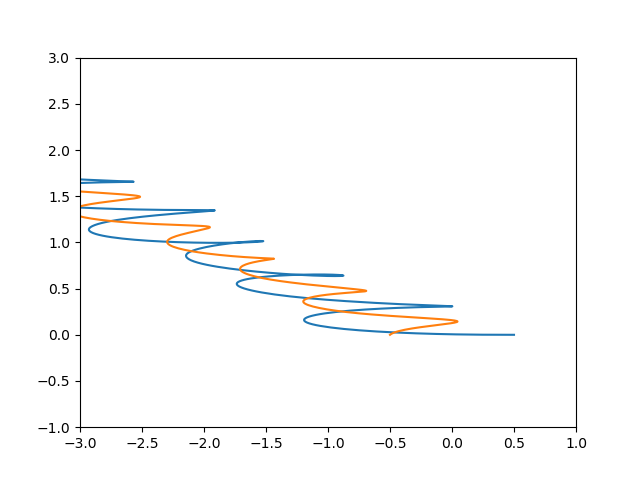

In [69]:
N = 50
T = 500
masses = np.array([1.1,1.9])
pos = np.array([(0.5,0,0),(-0.5,0,0)])
vel = np.array([(-0.05, 0, 0.1),(0.01, 0.01, 0)])


%matplotlib nbagg

fig = plt.figure("Euler para 2 masas")
ax = plt.axes(xlim=(-3, 1), ylim=(-1, 3))
line1, = ax.plot([], [])
line2, = ax.plot([], [])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    
    
def animate(i):
    resp1 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,0]
    resp2 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,1]
    
    x1 = resp1[:,0]
    y1 = resp1[:,1]
    x2 = resp2[:,0]
    y2 = resp2[:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    
anim = FuncAnimation(fig, animate, init_func=init, frames=500)


<IPython.core.display.Javascript object>


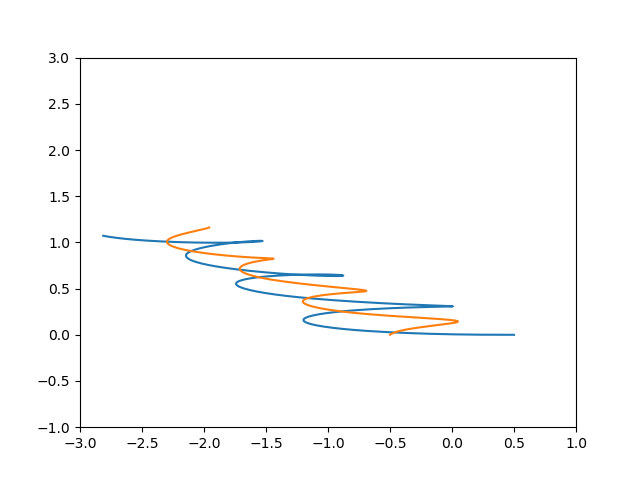

In [76]:
N = 50
T = 500
masses = np.array([1.1,1.9])
pos = np.array([(0.5,0,0),(-0.5,0,0)])
vel = np.array([(-0.05, 0, 0.1),(0.01, 0.01, 0)])


%matplotlib nbagg

fig = plt.figure("RK4 para 2 masas")
ax = plt.axes(xlim=(-3, 1), ylim=(-1, 3))
line1, = ax.plot([], [])
line2, = ax.plot([], [])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    
    
def animate(i):
    resp1 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,0]
    resp2 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,1]
    
    x1 = resp1[:,0]
    y1 = resp1[:,1]
    x2 = resp2[:,0]
    y2 = resp2[:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    
anim = FuncAnimation(fig, animate, init_func=init, frames=500)

<IPython.core.display.Javascript object>


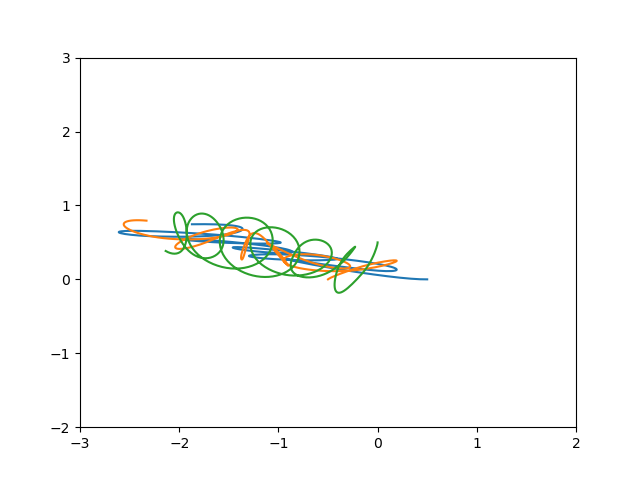

In [72]:
N = 50
T = 500
masses = np.array([1.1,1.9,0.9])
pos = np.array([[0.5,0,0],[-0.5,0,0], [0,0.5,0]])
vel = np.array([[-0.05,0,0.1],[0.01,0.01,0],[0,-0.01,0]])

%matplotlib nbagg

fig = plt.figure("Euler para 3 masas")
ax = plt.axes(xlim=(-3, 2), ylim=(-2, 3))
line1, = ax.plot([], [])
line2, = ax.plot([], [])
line3, = ax.plot([], [])
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
def animate(i):
    resp1 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,0]
    resp2 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,1]
    resp3 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,2]
    
    x1 = resp1[:,0]
    y1 = resp1[:,1]
    x2 = resp2[:,0]
    y2 = resp2[:,1]
    x3 = resp3[:,0]
    y3 = resp3[:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    line3.set_data(x3,y3)
    
anim = FuncAnimation(fig, animate, init_func=init, frames=500)

<IPython.core.display.Javascript object>


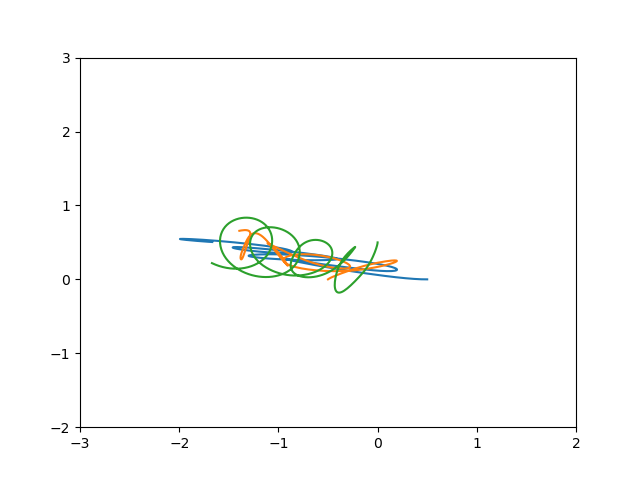

In [75]:
N = 50
T = 500
masses = np.array([1.1,1.9,0.9])
pos = np.array([[0.5,0,0],[-0.5,0,0], [0,0.5,0]])
vel = np.array([[-0.05,0,0.1],[0.01,0.01,0],[0,-0.01,0]])

%matplotlib nbagg

fig = plt.figure("RK4 para 3 masas")
ax = plt.axes(xlim=(-3, 2), ylim=(-2, 3))
line1, = ax.plot([], [])
line2, = ax.plot([], [])
line3, = ax.plot([], [])
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    
def animate(i):
    resp1 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,0]
    resp2 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,1]
    resp3 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,2]
    
    x1 = resp1[:,0]
    y1 = resp1[:,1]
    x2 = resp2[:,0]
    y2 = resp2[:,1]
    x3 = resp3[:,0]
    y3 = resp3[:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    line3.set_data(x3,y3)
    
anim = FuncAnimation(fig, animate, init_func=init, frames=500)

<IPython.core.display.Javascript object>


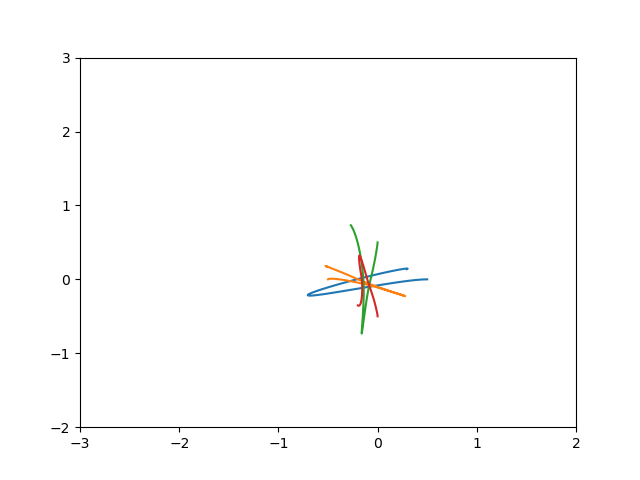

In [81]:
N = 50
T = 500
masses = np.array([1.1,1.9,0.9,2.8])
pos = np.array([[0.5,0,0],[-0.5,0,0], [0,0.5,0],[0,-0.5,0]])
vel = np.array([[-0.05,0,0.1],[0.01,0.01,0],[0,-0.01,0],[0,0.01,0]])

%matplotlib nbagg

fig = plt.figure("Euler para 4 masas")
ax = plt.axes(xlim=(-3, 2), ylim=(-2, 3))
line1, = ax.plot([], [])
line2, = ax.plot([], [])
line3, = ax.plot([], [])
line4, = ax.plot([], [])
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    
def animate(i):
    resp1 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,0]
    resp2 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,1]
    resp3 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,2]
    resp4 =  ode_solver(masses,pos,vel,i,T,'Euler')[:,3]
    
    x1 = resp1[:,0]
    y1 = resp1[:,1]
    x2 = resp2[:,0]
    y2 = resp2[:,1]
    x3 = resp3[:,0]
    y3 = resp3[:,1]
    x4 = resp4[:,0]
    y4 = resp4[:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    line3.set_data(x3,y3)
    line4.set_data(x4,y4)
    
anim = FuncAnimation(fig, animate, init_func=init, frames=500)

<IPython.core.display.Javascript object>


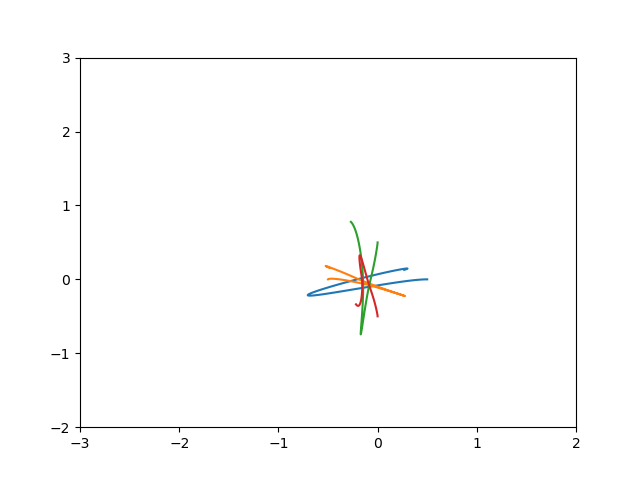

In [82]:
N = 50
T = 500
masses = np.array([1.1,1.9,0.9,2.8])
pos = np.array([[0.5,0,0],[-0.5,0,0], [0,0.5,0],[0,-0.5,0]])
vel = np.array([[-0.05,0,0.1],[0.01,0.01,0],[0,-0.01,0],[0,0.01,0]])

%matplotlib nbagg

fig = plt.figure("RK4 para 4 masas")
ax = plt.axes(xlim=(-3, 2), ylim=(-2, 3))
line1, = ax.plot([], [])
line2, = ax.plot([], [])
line3, = ax.plot([], [])
line4, = ax.plot([], [])
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    
def animate(i):
    resp1 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,0]
    resp2 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,1]
    resp3 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,2]
    resp4 =  ode_solver(masses,pos,vel,i,T,'RK4')[:,3]
    
    x1 = resp1[:,0]
    y1 = resp1[:,1]
    x2 = resp2[:,0]
    y2 = resp2[:,1]
    x3 = resp3[:,0]
    y3 = resp3[:,1]
    x4 = resp4[:,0]
    y4 = resp4[:,1]
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    line3.set_data(x3,y3)
    line4.set_data(x4,y4)
    
anim = FuncAnimation(fig, animate, init_func=init, frames=500)

4. Usando su código de la sección anterior, estudie el efecto del parámetro $\Delta t$. Para esto intente encontrar un $\Delta t$ de manera que sus soluciones con ambos métodos sean visualmente similares. Para esto puede usar los parámetros de la sección anterior. Concluya respecto a la estabilidad de la solución en función del parámetro $\Delta t$.

R: Tanto en Euler como RK4 obtengo los mismo resultados.

## Sección 2: Backward Euler

El método de Backward Euler (o Euler Implícito) es similar al método clasico de Euler, pero en lugar de aproximar la integral con Riemman por la izquierda, la aproxima con una integral de Riemann por la derecha, es decir:
\begin{equation}
    \mathbf{y}_{i+1}=y_{i}+\Delta t\,\mathbf{f}(t_{i+1},\mathbf{y}_{i+1}),
\end{equation}
por lo que es necesario resolver un problema de búsqueda de ceros multidimensional en cada paso.

1. Implemente la función adjunta `ode_solver_2` para que permita resolver el problema *n-body* utilizando el método de Backward Euler.

R: Se puede ocupar el jacobiano para poder obtener la busqueda de ceros.

In [85]:
'''
Input:
masses - (array) List of masses of bodies. Its dimension is n
pos - (array) List of initial positions of bodies in 3d (x0, y0 and z0). Its dimension is n x 3.
vel - (array) List of initial positions of bodies in 3d (x0', y0' and z0'). Its dimension is n x 3.
N -  (integer) Number of points in the mesh
T - (int) Simulation's lenght
method - (string) Euler, RK4 or BackEuler
Output:
y - (array) Array with positions of bodies. Its dimension is T*h x n x 3
'''
def ode_solver_2(masses, pos, vel, N, T, method):
    G=4.3e-3 # pc*M_s^-1*km^2/s^2
    n=masses.size
    y = np.zeros((N,n,3))
    
    if method == 'BackEuler':
        y = np.zeros((N,n,3))
        # Your code goes here!
        
    elif method == "Euler" or method == "RK4":
        # Use the previous solver!
        ode_solver(masses, pos, vel, N, T, method)
    
    return y

2. Use un widget para graficar sus resultados con los parámetros entregados en la sección anterior, esta vez solo modificando el valor de $\Delta t$ para los métodos de Euler, Backward Euler y Runge Kutta 4. Concluya como se modifican sus resultados.

In [86]:
def ode_solver_2_interface(N, T, method):
    masses=np.array([1.1,1.9])
    pos=np.array([[0.5,0,0],[-0.5,0,0]])
    vel=np.array([[-0.05,0,0.01],[0.01,0.01,0]])
    y = ode_solver_2(masses, pos, vel, 2**N, T, method)
    # Your code and plots goes here!

    
interact_manual(ode_solver_2_interface,N=widgets.IntSlider(min=1, max=20),T=fixed(100),method=["Euler","RK4","BackEuler"])

interactive(children=(IntSlider(value=1, description='N', max=20, min=1), Dropdown(description='method', optio…

<function __main__.ode_solver_2_interface(N, T, method)>

In [45]:
L = 15
def F(t,y0):
    sol=np.zeros(3)
    sol[0]=((-y0[0]*y0[1])/20)+(y0[1]**2)*np.sin(y0[2])
    sol[1]=((y0[0]**2)/20)-(y0[0]*y0[1]*np.sin(y0[2]))
    sol[2]=1
    return sol
def F2(t,y0):
    sol=np.zeros(2)
    sol[0]=((-y0[0]*y0[1])/20)+(y0[1]**2)*np.sin(t)
    sol[1]=((y0[0]**2)/20)-(y0[0]*y0[1]*np.sin(t))
    return sol
def euler_ode(y,t,f,h):
    return y+h*f(t,y)
def RK2_ode(y,t,f,h):
    k1=y+h/2.0*f(t,y) #or euler_ode(y,t,f,h)
    return y+h*f(t+h/2.0,k1)
    # k1=h*f(t,y)
    # return y+h*f(t+h/2.0,y+k1/2.0)

# Runge-Kutta 
def RK4_ode(y,t,f,h):
    k1=f(t,y)
    k2=f(t+h/2.0,y+(h/2.0)*k1)
    k3=f(t+h/2.0,y+(h/2.0)*k2)
    k4=f(t+h,y+h*k3)
    return y+(h/6.0)*(k1+2.0*k2+2.0*k3+k4)
def solucionarTarea(N, T):
    y0=[np.cos(np.pi/4), np.sin(np.pi/4)]
    h = N/T
    t_times = np.arange(0, T, h)
    y_output = np.zeros([t_times.size,2])
    y_output[0,:] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],F2,h)
    #print(y_output)
    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    
    ax1.axis('equal')
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[:,0],'b-')
    ax1.plot(t_times,y_output[:,1],'r-')
    #ax1.axis([0, T, 0, 10])
    
def solucionarTarea2(N, T):
    y0=[np.cos(np.pi/4), np.sin(np.pi/4),0]
    h = N/T
    t_times = np.arange(0, T, h)
    y_output = np.zeros([t_times.size,3])
    y_output[0,:] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],F,h)
    #print(y_output)
    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    
    ax1.axis('equal')
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[:,0],'b-')
    ax1.plot(t_times,y_output[:,1],'r-')
    ax1.plot(t_times,y_output[:,2],'g-')
    #ax1.axis([0, T, 0, 10])

    

interact(solucionarTarea,N=(0,100,1),T=(0,1000,10))

interactive(children=(IntSlider(value=50, description='N'), IntSlider(value=500, description='T', max=1000, st…

<function __main__.solucionarTarea(N, T)>

In [51]:
def solucionarTarea3(N, T, omega):
    y0=[np.cos(omega), np.sin(omega),0]
    h = N/T
    t_times = np.arange(0, T, h)
    y_output = np.zeros([t_times.size,3])
    y_output[0,:] = y0
    for i in range(1,t_times.size):
        y_output[i]=RK4_ode(y_output[i-1],t_times[i-1],F,h)
    #print(y_output)
    fig = plt.figure(figsize=(L,L))
    ax1 = fig.add_subplot(221)
    
    ax1.axis('equal')
    ax1.grid(True)
    ax1.set_title('Numerical Approximation')
    ax1.plot(t_times,y_output[:,0],'b-')
    ax1.plot(t_times,y_output[:,1],'r-')
    #ax1.plot(t_times,y_output[:,2],'g-')
    #ax1.axis([0, T, 0, 10])
    
interact(solucionarTarea3,N=(0,100,1),T=(0,1000,10),omega=(0,50,0.1))

interactive(children=(IntSlider(value=50, description='N'), IntSlider(value=500, description='T', max=1000, st…

<function __main__.solucionarTarea3(N, T, omega)>

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

---

# Referencias


[1] https://es.wikipedia.org/wiki/Alfa_Centauri

https://github.com/tclaudioe/Scientific-Computing/blob/master/SC2/U3_ODE.ipynb